# A Citation Graph from OpenAlex (Works) — Dataset Overview

This notebook provides a **mount-first** overview of the Illinois Data Bank dataset **IDB-7362697** (“A Citation Graph from OpenAlex (Works)”).

## What this dataset contains (per the dataset description)

The release includes **two `.xz` files**:

1. `openalexID_integer_id_hasDOI.parquet.xz`  
   A node/ID mapping table with **three columns**:
   - `openalex_id` (string)
   - `integer_id` (int; new identifier assigned by the dataset authors)
   - `hasDOI` (0/1 int)

2. `citation_table.tsv.xz`  
   A citation edge list with **two integer columns (no header)**:
   - `citing_integer_id`
   - `cited_integer_id`

## Design goals

- **No downloading**: assumes the dataset is already mounted somewhere under `SETTINGS.DATA_ROOT`.
- **Streaming-friendly**: the edge list is huge, so we avoid loading it fully into memory.
- **Explainability**: each section includes markdown explaining what’s happening and why.


In [2]:
# ============================================================
# 0) Project setup (same pattern as your Higgs notebook)
#    - find repo root by locating `src/`
#    - import SETTINGS from src.core.config
# ============================================================
from pathlib import Path
import sys

def find_repo_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "src").is_dir():
            return p
    raise FileNotFoundError("Could not find repo root containing `src/`")

REPO_ROOT = find_repo_root()
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from src.core.config import SETTINGS  # noqa: E402

print("REPO_ROOT:", REPO_ROOT)
print("DATA_ROOT:", SETTINGS.DATA_ROOT)


REPO_ROOT: /mnt/c/Users/rescic/PycharmProjects/dezinfo-datasets
DATA_ROOT: /home/rescic/dezinfo_data


## 1) Point to the mounted dataset folder

Just like in your Higgs notebook, we assume you already mounted the dataset locally (e.g., via a shared filesystem, NFS, object store mount, etc.).

Set `DATASET_SUBDIR` to the folder name under `SETTINGS.DATA_ROOT` that contains the `.xz` files.


In [3]:
# ---- change this to your mount folder name ----
DATASET_SUBDIR = "openalexCG"  # <-- set to your mounted folder name

DATASET_DIR = Path(SETTINGS.DATA_ROOT) / DATASET_SUBDIR
assert DATASET_DIR.exists(), f"Mounted dataset folder not found: {DATASET_DIR}"
print("DATASET_DIR:", DATASET_DIR)

# Quick glance at top-level contents
print("\nTop-level listing (first 50 entries):")
for p in sorted(DATASET_DIR.iterdir())[:50]:
    print(" ", p.name)


DATASET_DIR: /home/rescic/dezinfo_data/openalexCG

Top-level listing (first 50 entries):
  citation_table.tsv.xz
  dataset_info.txt
  openalexID_integer_id_hasDOI.parquet.xz


## 2) Locate the expected files

The dataset should contain:
- `openalexID_integer_id_hasDOI.parquet.xz` (node table)
- `citation_table.tsv.xz` (edge list)

To keep this notebook robust to minor filename changes (or nested folders), we search by patterns.


In [4]:
def find_first(dataset_dir: Path, patterns: list[str]) -> Path | None:
    for pat in patterns:
        hits = sorted(dataset_dir.rglob(pat))
        if hits:
            return hits[0]
    return None

NODE_PARQUET_XZ = find_first(DATASET_DIR, ["openalexID_integer_id_hasDOI.parquet.xz", "*integer*hasDOI*.parquet.xz", "*.parquet.xz"])
EDGE_TSV_XZ     = find_first(DATASET_DIR, ["citation_table.tsv.xz", "*citation*.tsv.xz", "*.tsv.xz"])

print("NODE_PARQUET_XZ:", NODE_PARQUET_XZ)
print("EDGE_TSV_XZ:", EDGE_TSV_XZ)

assert NODE_PARQUET_XZ is not None, "Could not locate the parquet.xz node table in the mounted folder."
assert EDGE_TSV_XZ is not None, "Could not locate the citation_table.tsv.xz edge list in the mounted folder."


NODE_PARQUET_XZ: /home/rescic/dezinfo_data/openalexCG/openalexID_integer_id_hasDOI.parquet.xz
EDGE_TSV_XZ: /home/rescic/dezinfo_data/openalexCG/citation_table.tsv.xz


## 3) Inspect the node table (`.parquet.xz`) — metadata first

Parquet is a columnar format with rich metadata. Even if the full file is large, we can typically read:

- the **schema** (column names and types)
- the **row count**
- number of **row groups**

Because the file is compressed with `xz`, we have two options:

1) **Simpler (in-memory)**: decompress the `.xz` stream into memory and open it with PyArrow.  
   - Works when the compressed parquet is not too large for RAM.
2) **More robust (on-disk)**: decompress to a temporary `.parquet` file on disk and open with PyArrow.  
   - Recommended if you hit memory limits.

This notebook tries the simpler approach first and provides an on-disk fallback.


In [5]:
import lzma
import io
import pyarrow.parquet as pq

def parquet_xz_parquetfile_in_memory(parquet_xz_path: Path) -> pq.ParquetFile:
    # Decompress into memory (may be large; see fallback if needed)
    with lzma.open(parquet_xz_path, "rb") as f:
        raw = f.read()
    buf = io.BytesIO(raw)
    return pq.ParquetFile(buf)

try:
    pf = parquet_xz_parquetfile_in_memory(NODE_PARQUET_XZ)
    print("Row count:", pf.metadata.num_rows)
    print("Row groups:", pf.metadata.num_row_groups)
    print("Schema:")
    print(pf.schema_arrow)
except MemoryError:
    pf = None
    print("MemoryError while loading parquet.xz into memory.")


Row count: 256997006
Row groups: 4
Schema:
openalex_id: string
integer_id: int64
hasDOI: int64
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 422


## 4) Preview a small sample of the node table

If we can create a `ParquetFile`, we can read just the **first row group** and show the first few rows.

This avoids building a full DataFrame for the entire dataset.


In [6]:
import pandas as pd

def parquet_head_from_parquetfile(pf: pq.ParquetFile, n: int = 10) -> pd.DataFrame:
    # Read only the first row group (usually a manageable chunk)
    rg0 = pf.read_row_group(0)
    return rg0.to_pandas().head(n)

if pf is not None:
    display(parquet_head_from_parquetfile(pf, n=10))


,openalex_id,integer_id,hasDOI
0,W100000002,0,1
1,W1000000047,1,0
2,W1000000056,2,0
3,W1000000079,3,0
4,W100000009,4,0
5,W1000000094,5,0
6,W1000000139,6,0
7,W1000000144,7,0
8,W1000000158,8,0
9,W1000000244,9,0


## 5) Stream the citation edge list (`citation_table.tsv.xz`)

The citation file is a **two-column edge list** (no header). It can be very large.

We avoid `pandas.read_csv()` on the whole thing and instead:

- stream the file line-by-line from the `.xz` stream,
- optionally take a **uniform sample of edges** using reservoir sampling,
- compute approximate in/out degree summaries from the sample.

This gives a solid “shape” of the graph without processing billions of edges in-memory.


In [7]:
from typing import Iterator, Tuple
import random
from collections import Counter
import numpy as np

def stream_edges_tsv_xz(path: Path) -> Iterator[Tuple[int, int]]:
    """Yield (citing_integer_id, cited_integer_id) from a .tsv.xz edge list."""
    with lzma.open(path, "rt", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            a = line.split()  # works for tab or whitespace
            if len(a) < 2:
                continue
            yield int(a[0]), int(a[1])

def reservoir_sample_edges(edge_iter: Iterator[Tuple[int, int]], k: int, seed: int = 0):
    """Uniform reservoir sample of k edges from a stream."""
    rng = random.Random(seed)
    sample = []
    for i, e in enumerate(edge_iter, start=1):
        if i <= k:
            sample.append(e)
        else:
            j = rng.randint(1, i)
            if j <= k:
                sample[j - 1] = e
    return sample

# ---- config: start small, increase if you have time/RAM ----
EDGE_SAMPLE_K = 500_000   # 0.5M edges ~ quick sanity; raise to 2-5M for smoother stats
SEED = 42

edge_sample = reservoir_sample_edges(stream_edges_tsv_xz(EDGE_TSV_XZ), k=EDGE_SAMPLE_K, seed=SEED)
print("Sampled edges:", len(edge_sample))

out_deg = Counter()
in_deg = Counter()
for u, v in edge_sample:
    out_deg[u] += 1
    in_deg[v] += 1

out_vals = np.fromiter(out_deg.values(), dtype=np.int64)
in_vals  = np.fromiter(in_deg.values(),  dtype=np.int64)

def summarize_degrees(arr: np.ndarray, name: str):
    if arr.size == 0:
        print(name, ": empty")
        return
    qs = np.quantile(arr, [0.5, 0.9, 0.99, 0.999])
    print(f"{name}: n={arr.size:,}  mean={arr.mean():.3f}  median/p90/p99/p99.9={qs}")

summarize_degrees(out_vals, "Sample out-degree (citing count)")
summarize_degrees(in_vals,  "Sample in-degree (cited count)")


Sampled edges: 500000
Sample out-degree (citing count): n=495,484  mean=1.009  median/p90/p99/p99.9=[1. 1. 1. 2.]
Sample in-degree (cited count): n=477,871  mean=1.046  median/p90/p99/p99.9=[1. 1. 2. 5.]


## 6) Visualize sampled degree distributions

Citation graphs usually have heavy-tailed degree distributions.

A log-scaled histogram helps confirm the heavy-tail pattern and catch obvious parsing errors (e.g., if degrees look uniform or tiny due to reading the wrong columns).


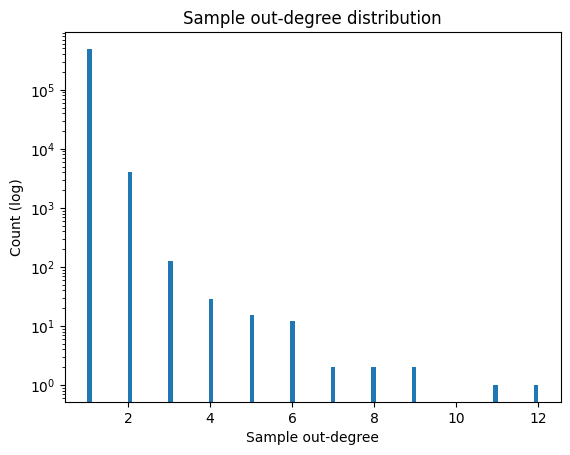

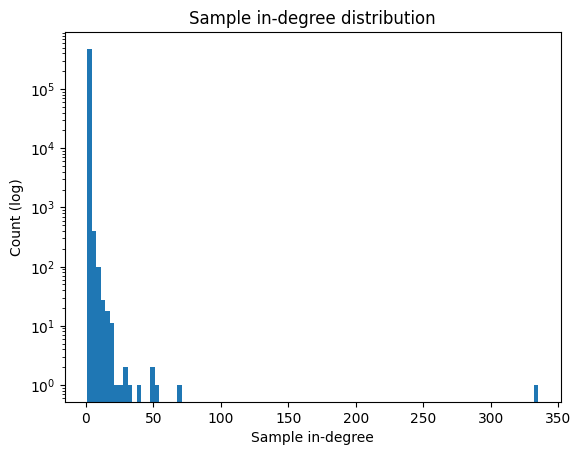

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(out_vals, bins=100, log=True)
plt.xlabel("Sample out-degree")
plt.ylabel("Count (log)")
plt.title("Sample out-degree distribution")
plt.show()

plt.figure()
plt.hist(in_vals, bins=100, log=True)
plt.xlabel("Sample in-degree")
plt.ylabel("Count (log)")
plt.title("Sample in-degree distribution")
plt.show()


## 8) Optional: estimate reciprocity on the sampled edges

In a citation graph, reciprocity (mutual citations) is usually low, but it can exist.

This calculation is **sample-based**:
- build a set of sampled edges
- count how many have their reverse present in the same sample


In [9]:
edge_set = set(edge_sample)
mutual = sum(1 for (u, v) in edge_sample if (v, u) in edge_set)
print("Sample mutual edges:", mutual)
print("Sample reciprocity (edge-level):", mutual / max(1, len(edge_sample)))


Sample mutual edges: 129
Sample reciprocity (edge-level): 0.000258


## 9) Optional: join sample edges to DOI availability (endpoint DOI flags)

If the node table is accessible, we can estimate in the sample:
- fraction of edges where **both endpoints have DOIs**
- fraction where **exactly one** endpoint has a DOI
- fraction where **neither** endpoint has a DOI

Because the node table is huge, we **only build DOI flags** for nodes that appear in the sampled edges.


In [10]:
# This cell builds a tiny DOI lookup for only the nodes in the edge sample.
# It expects node parquet columns: integer_id, hasDOI.

if pf is not None:
    sample_nodes = set()
    for u, v in edge_sample:
        sample_nodes.add(u); sample_nodes.add(v)
    print("Unique nodes in edge sample:", len(sample_nodes))

    doi = {}
    for rg_idx in range(pf.metadata.num_row_groups):
        rg = pf.read_row_group(rg_idx, columns=["integer_id", "hasDOI"])
        df = rg.to_pandas()
        hit = df[df["integer_id"].isin(sample_nodes)]
        for iid, hasdoi in zip(hit["integer_id"].tolist(), hit["hasDOI"].tolist()):
            doi[int(iid)] = int(hasdoi)
        if len(doi) == len(sample_nodes):
            break

    print("Resolved DOI flags for nodes:", len(doi))

    both_doi = 0
    one_doi = 0
    none_doi = 0
    unknown = 0

    for u, v in edge_sample:
        hu = doi.get(u)
        hv = doi.get(v)
        if hu is None or hv is None:
            unknown += 1
        else:
            if hu == 1 and hv == 1:
                both_doi += 1
            elif hu == 0 and hv == 0:
                none_doi += 1
            else:
                one_doi += 1

    total = len(edge_sample)
    print("Edge sample DOI endpoint breakdown:")
    print("  both have DOI:", both_doi, f"({both_doi/total:.3%})")
    print("  exactly one DOI:", one_doi, f"({one_doi/total:.3%})")
    print("  neither DOI:", none_doi, f"({none_doi/total:.3%})")
    print("  unknown (missing mapping):", unknown, f"({unknown/total:.3%})")
else:
    print("Skipping: node parquet not available in-memory. Use the disk fallback if needed.")


Unique nodes in edge sample: 969466
Resolved DOI flags for nodes: 969466
Edge sample DOI endpoint breakdown:
  both have DOI: 450576 (90.115%)
  exactly one DOI: 43593 (8.719%)
  neither DOI: 5831 (1.166%)
  unknown (missing mapping): 0 (0.000%)
